In [1]:
import importlib
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime # for 

dir = os.getcwd()
os.chdir("/home/clueken/python_scripts")
import open_era5_utils
importlib.reload(open_era5_utils)
from open_era5_utils import add_world_map#import the module here, so that it can be reloaded.
os.chdir(dir)

In [2]:
os.chdir("/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0")
file = 'obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_chl_surface-insitu_6_allvalid.nc'

dataset = xr.open_mfdataset(file, combine='by_coords',concat_dim='None')
values = dataset.value.values
print(dataset)

<xarray.Dataset>
Dimensions:                     (calendar_components: 6, dim_concerns: 6, mip_nmodels: 17, obs: 52752)
Dimensions without coordinates: calendar_components, dim_concerns, mip_nmodels, obs
Data variables:
    time                        (obs) datetime64[ns] dask.array<chunksize=(52752,), meta=np.ndarray>
    start_time                  (obs) datetime64[ns] dask.array<chunksize=(52752,), meta=np.ndarray>
    midpoint_time               (obs) datetime64[ns] dask.array<chunksize=(52752,), meta=np.ndarray>
    datetime                    (obs) |S100 dask.array<chunksize=(52752,), meta=np.ndarray>
    time_decimal                (obs) float64 dask.array<chunksize=(52752,), meta=np.ndarray>
    time_components             (obs, calendar_components) float64 dask.array<chunksize=(52752, 6), meta=np.ndarray>
    solartime_components        (obs, calendar_components) float64 dask.array<chunksize=(52752, 6), meta=np.ndarray>
    value                       (obs) float32 dask.array<

In [3]:
#average controlled by avg_index: year:1, month:2, etc

#vllt mit datetime machen
def avg_by_time(dataset, avg_index=2):
    keys = ["Y", "M", "D", "h", "m", "s"]
    v_list = []
    t_list = []
    t, ind = np.unique(dataset.time_components.values[:,:avg_index], axis=0, return_index=True)
    for i in range(len(t)-1):
        
        t_list.append(dataset.time.values[ind[i]].astype("datetime64[{}]".format(keys[avg_index-1])))
        v = np.mean(dataset.value.values[ind[i]: ind[i+1]])
        v_list.append(v)
    return np.array(v_list), t_list


In [ ]:

file_dir = '/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc'
f = os.listdir(file_dir)
filenames = []
for file in f:
    filenames.append(file) if "surface" in file else None

filenames = filenames

#fig1, ax1 = plt.subplots(figsize=(10, 7))
#fig2, ax2 = plt.subplots(figsize=(10, 7))

#fig1, ax1 = add_world_map(fig1, ax1, color="gray", alpha=0.5, edgecolor="black")
aust_file_names = []

for i,f in enumerate(filenames):
    file = os.path.join(file_dir, f)
    dataset = xr.open_mfdataset(file, combine='by_coords',concat_dim='None')
    #ax1.scatter(dataset.longitude[0], dataset.latitude[0], color=c_list[i], s=100)#
    print(i)
    print(dataset.lab_1_country)
    aust_file_names.append(file) if "Australia" == dataset.lab_1_country else None
np.savetxt("/home/clueken/python_scripts/data/obspack_austr_surface.txt", np.array(aust_file_names),fmt="%s")
#with open("/home/clueken/python_scripts/data/obspack_austr_surface.txt")as f:
#    lines = f.readlines()

/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cfa_surface-flask_2_representative.nc
<class 'str'>
/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_alt_surface-flask_2_representative.nc
<class 'str'>
/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cgo_surface-flask_2_representative.nc
<class 'str'>
/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_sis_surface-flask_2_representative.nc
<class 'str'>
/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_gpa_surface-flask_2_representative.nc
<class 'str'>
/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_ara_surface-flask_2_representative.nc
<class 'str'>
/mnt/data/

<function matplotlib.pyplot.show(*args, **kw)>

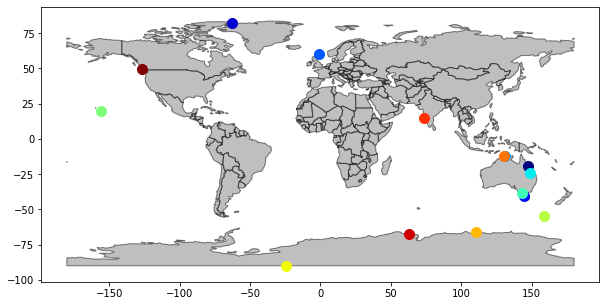

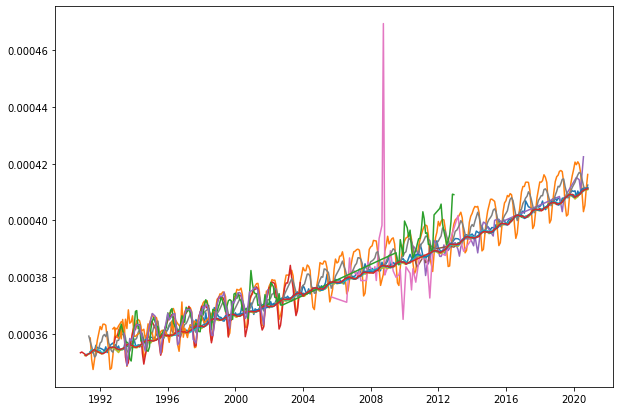

In [15]:
with open("/home/clueken/python_scripts/data/obspack_austr_surface.txt") as f:
    filenames = f.read().splitlines()
fig1, ax1 = plt.subplots(figsize=(10, 7))
fig2, ax2 = plt.subplots(figsize=(10, 7))
colors = cm.jet(np.linspace(0,1,len(filenames)))
fig1, ax1 = add_world_map(fig1, ax1, color="gray", alpha=0.5, edgecolor="black")

for i, f in enumerate(filenames):
    dataset = xr.open_mfdataset(f, combine='by_coords',concat_dim='None')
    ax1.scatter(dataset.longitude[0], dataset.latitude[0], color=colors[i], s=100)
    values, times = avg_by_time(dataset, 2)
    ax2.plot(times, values)
plt.show

In [5]:
dataset = xr.open_mfdataset("/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cfa_surface-flask_2_representative.nc", combine='by_coords',concat_dim='None')

In [113]:
"co2_cfa_surface-flask_2_representative.nc" in os.listdir()

True

In [114]:
dataset = xr.open_mfdataset("obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/", combine='by_coords',concat_dim='None')

OSError: no files to open

In [13]:
type(file)
file

'/mnt/data/users/eschoema/ObsPack_CO2_GLOBALVIEWplusv7.0/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc/co2_cfa_surface-flask_2_representative.nc\n'

In [11]:
print(type(str('lalal')))

<class 'str'>
